# Feature distributions

* Which features should be translated to log
* How features correlate
* PCA of features

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False

Imports and database setup

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from progressbar import ProgressBar

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.features import SubstitutionFeaturesMixin

First build our data

In [3]:
words = set()
for feature in SubstitutionFeaturesMixin.__features__:
    words.update(getattr(SubstitutionFeaturesMixin, '_' + feature)())

words = sorted(words)
data = dict((feature, np.zeros(len(words)))
            for feature in SubstitutionFeaturesMixin.__features__)
tdata = dict((SubstitutionFeaturesMixin._transformed_feature(feature).__doc__,
              np.zeros(len(words)))
             for feature in SubstitutionFeaturesMixin.__features__)
for i, word in enumerate(ProgressBar()(words)):
    for feature in SubstitutionFeaturesMixin.__features__:
        data[feature][i] = getattr(SubstitutionFeaturesMixin, '_' + feature)(word)
        tfeature = SubstitutionFeaturesMixin._transformed_feature(feature)
        tdata[tfeature.__doc__][i] = tfeature(word)

data['word'] = words
tdata['word'] = words
features = pd.DataFrame(data)
tfeatures = pd.DataFrame(tdata)
del data, tdata, words

100% (250191 of 250191) |###################################################################################################################################| Elapsed Time: 0:01:10 Time: 0:01:10


## 2 Which features should be translated to log

We compute the distribution of feature values, for each feature. When a distribution is very skewed, it's a good idea to translate it to log.

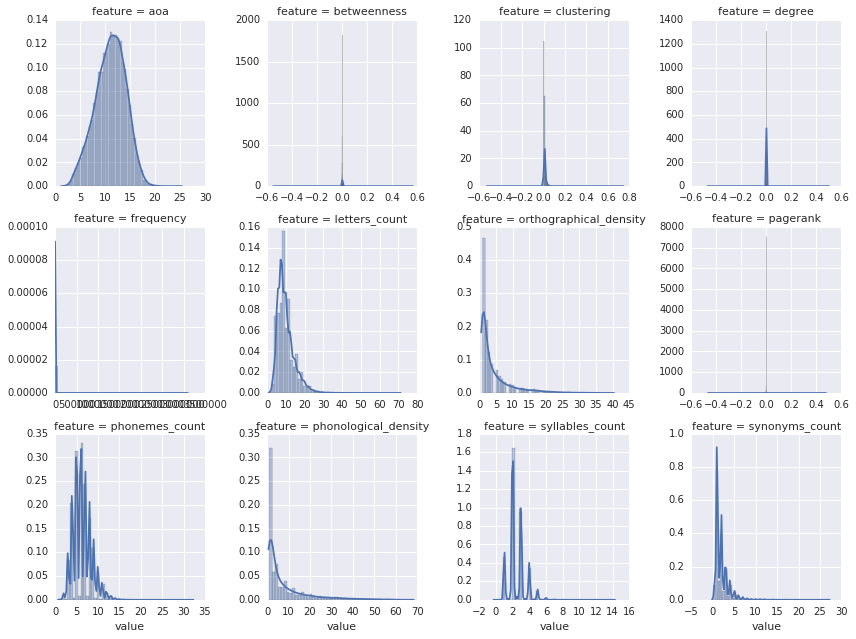

In [4]:
g = sb.FacetGrid(pd.melt(features, id_vars='word', var_name='feature'),
                 col='feature', col_wrap=4, sharex=False, sharey=False)
g.map(sb.distplot, 'value')

Conclusion: **all features except `aoa`, `letters_count`, `phonemes_count`, and `syllables_count` should be translated to log** so we can see better.

The result is the following.

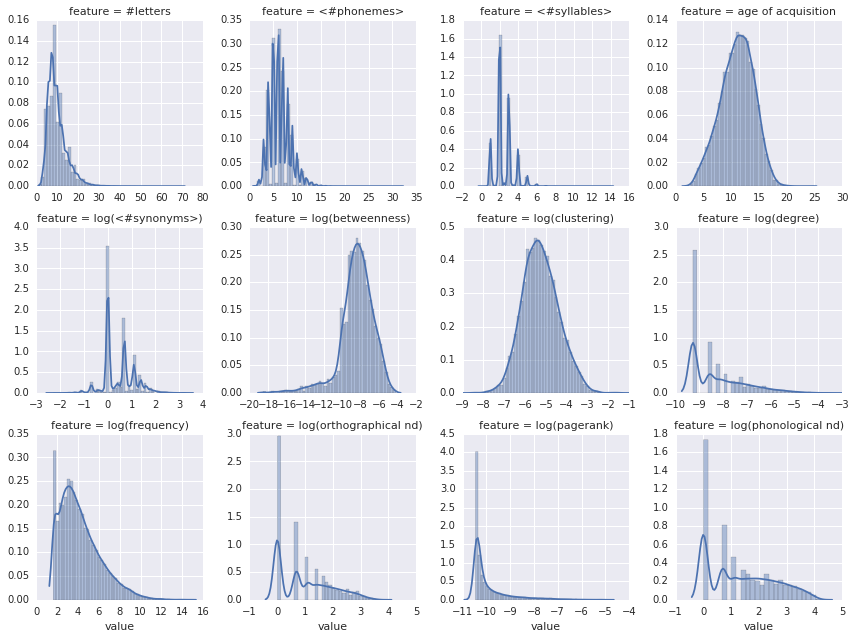

In [5]:
g = sb.FacetGrid(pd.melt(tfeatures, id_vars='word', var_name='feature'),
                 col='feature', col_wrap=4, sharex=False, sharey=False)
g.map(sb.distplot, 'value')

Which is quite a bit more readable.

## 3 Feature correlations

First the brute interactions between all features.

**CAVEAT**: because of [seaborn#407](https://github.com/mwaskom/seaborn/issues/407), the interactions are computed on the set of words where *all* features are defined (i.e. we drop all rows where any feature is NaN). So this graph is a preview, and not something publishable.

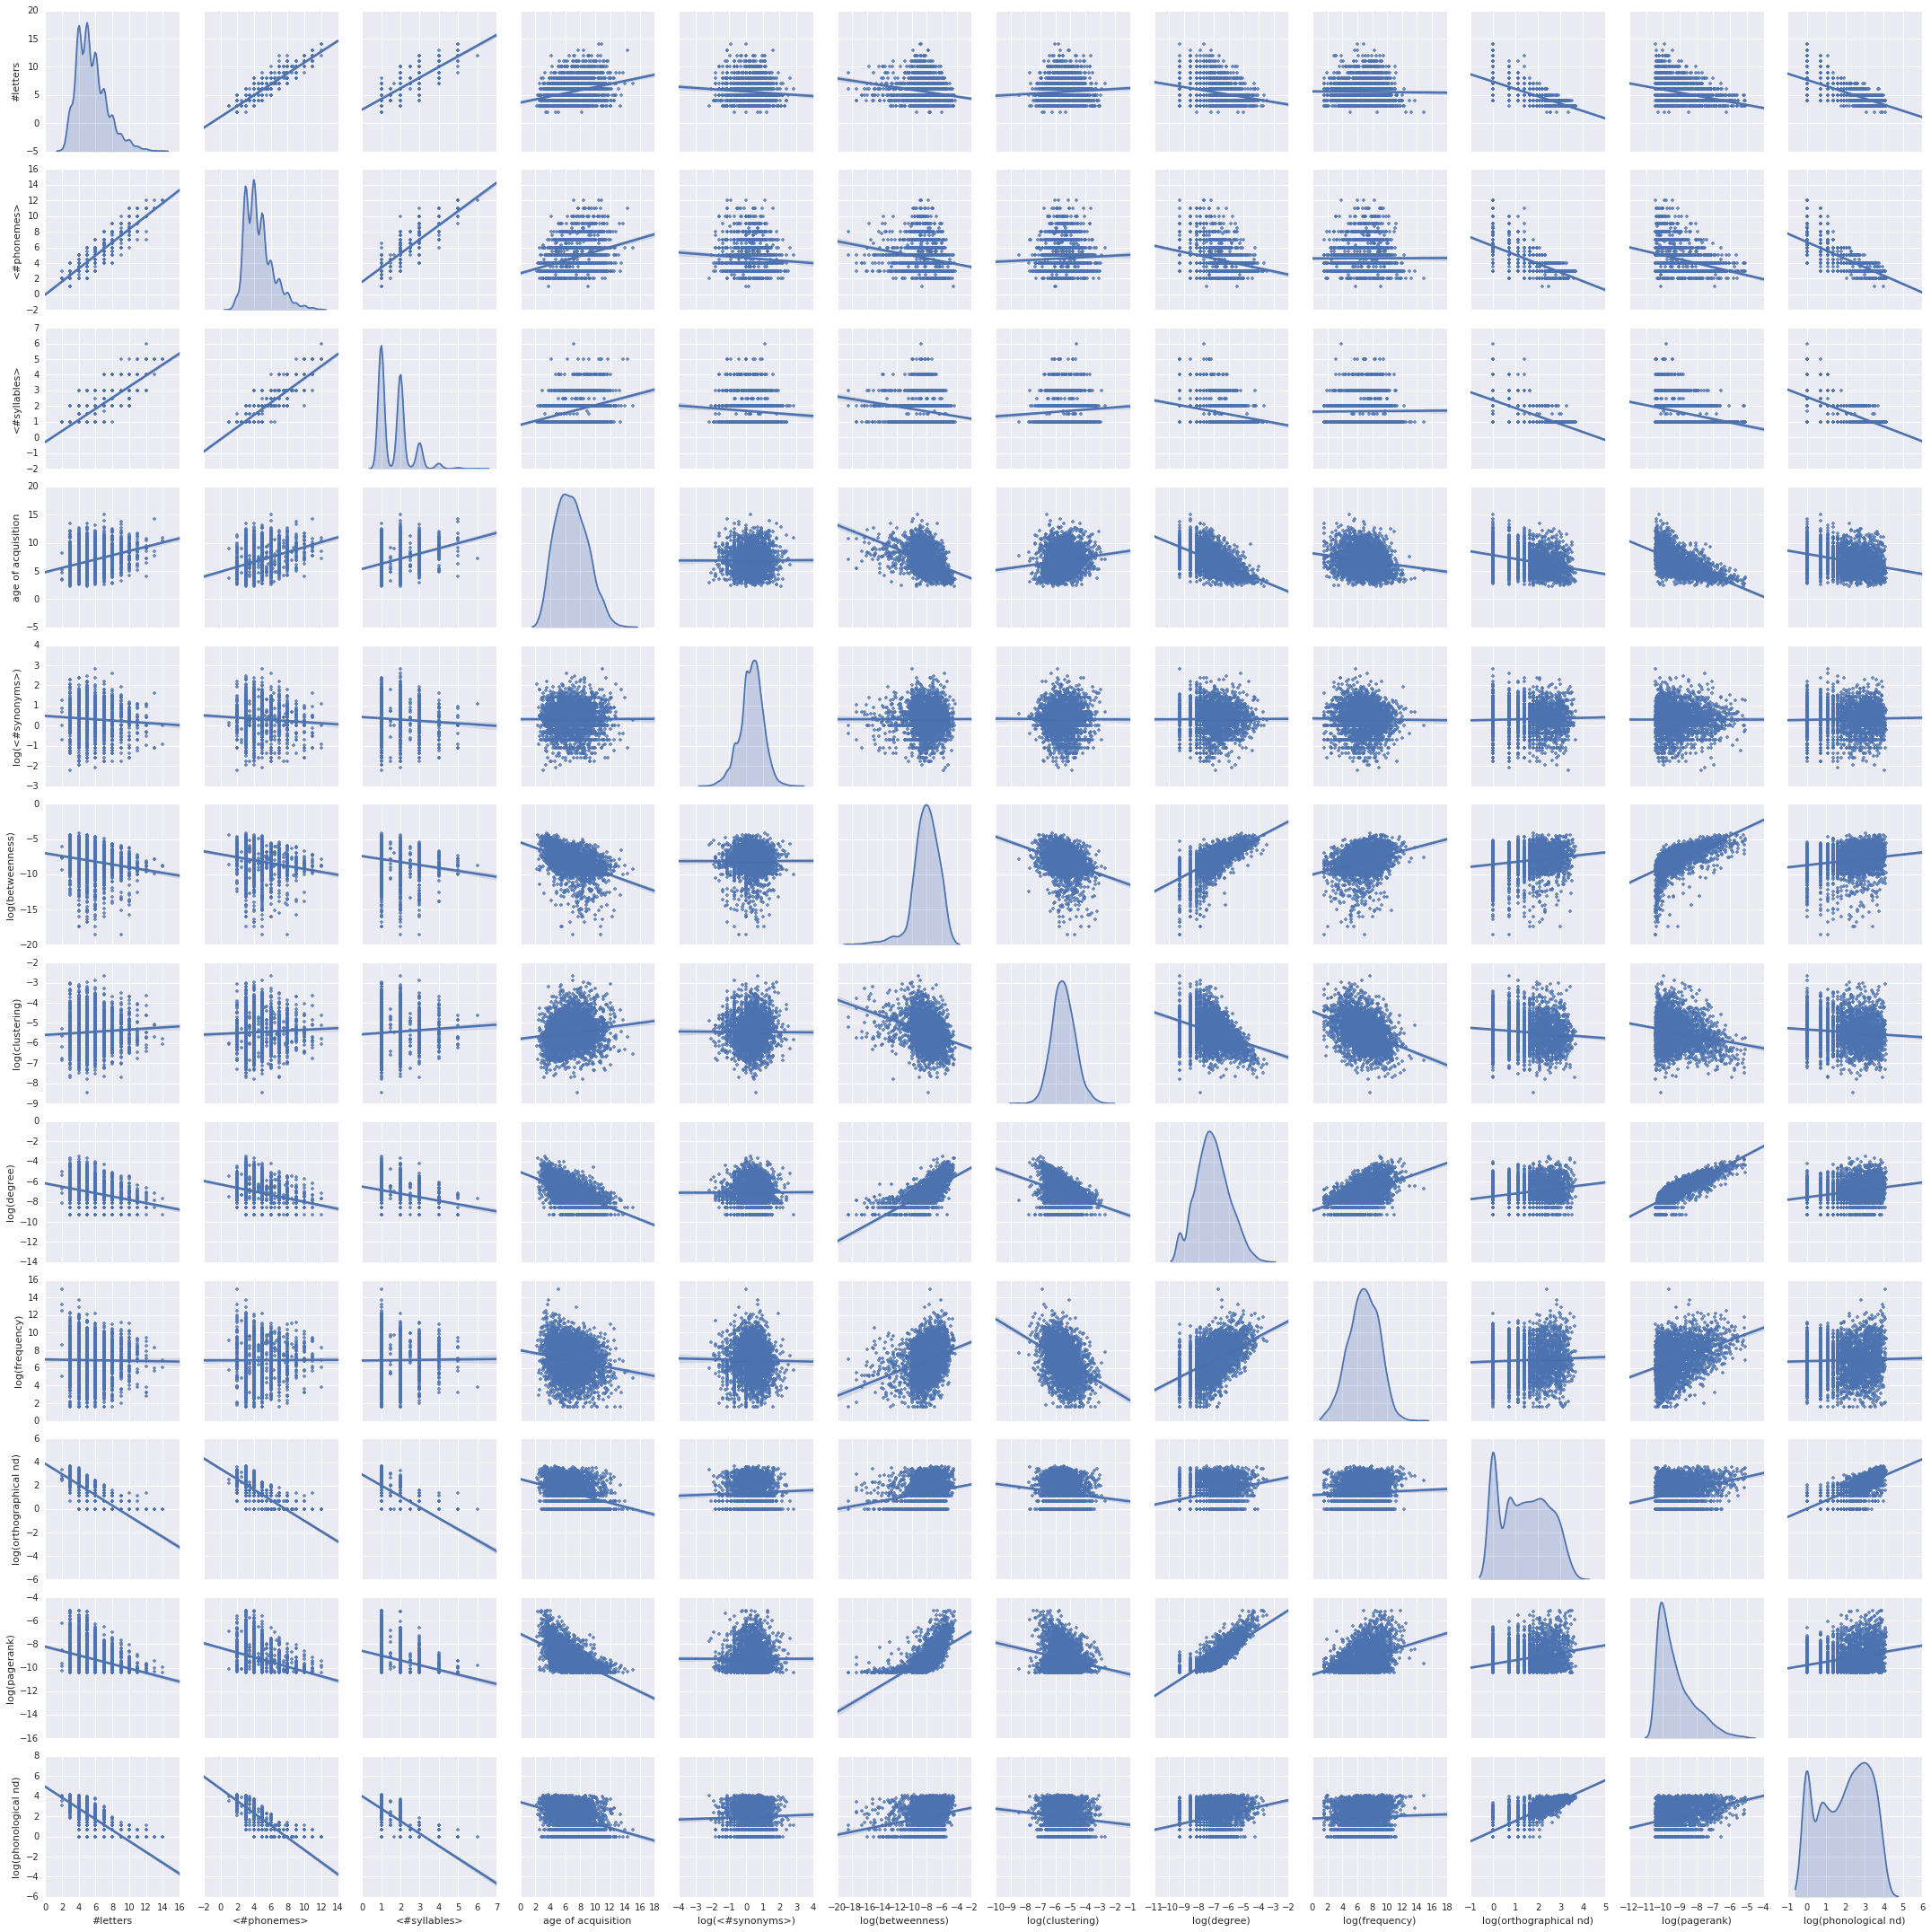

In [6]:
sb.pairplot(tfeatures.dropna(), kind='reg', markers="+",
            diag_kind="kde", diag_kws=dict(shade=True))

### 3.1 Pretty-plotting function for correlations

In [7]:
# Imports
from matplotlib import cm
from matplotlib.patches import Ellipse

def pretty_plot_correlations(data, scaling=1.0, cor_fontsize=30.0, label_fontsize=35.0):
    """Pretty-plot a correlation matrix.
    
    Parameters
    ----------
    data : pd.DataFrame
        DataFrame containing the variables for which to plot the correlation matrix.
    scaling : float, optional
        Scaling factor for the whole figure; for instance `2.0` would
        create a figure twice as big (for better resolution when saving);
        defaults to 1.0.
    cor_fontsize : float, optional
        Font size for the correlation values; defaults to 30.0.
    label_fontsize : float, optional
        Font size for the labels; defaults to 35.0.
    
    """
    
    # Some layout definitions.
    ellipse_lwidth = 1.5
    sep_crop = 0.2
    
    # Precompute useful values.
    correlations = data.corr()
    n_features = len(correlations)
    lims = np.linspace(0, 1, n_features + 1)
    step = 1 / n_features
    xs = lims[:-1] + step / 2
    esize = 0.98 * step
    
    # Create our figure.
    fig, ax = plt.subplots(figsize=(4 * scaling, 4 * scaling))
    
    # For all couples...
    for i in range(n_features):
        for j in range(n_features):
            # ...compute coordinates...
            x = xs[j]
            y = 1 - xs[i]
            cor = correlations.iloc[i, j]
            
            if i < j:
                # ...plot an Ellipse...
                color = cm.bwr((1 - cor) / 2)
                ax.add_patch(Ellipse([x, y], esize, esize * (1 - abs(cor)),
                             angle=np.sign(cor) * 45, ls='solid', lw=ellipse_lwidth,
                             ec='black', fc=color, alpha=0.8))
            
            elif i > j:
                # ...or show the correlation value.
                ax.text(x, y, "{:.2f}".format(cor).rstrip("0"),
                        fontsize=cor_fontsize,
                        horizontalalignment='center',
                        verticalalignment='center')
    
    # Add the line separators and labels.
    for i in range(n_features):
        # Line separator
        ax.plot([(i + sep_crop) * step, (i + 1 - sep_crop) * step],
                [1 - (i + 1 - sep_crop) * step, 1 - (i + sep_crop) * step],
                'k-', lw=ellipse_lwidth)
        
        # Horizontal label
        ax.text(- step / 2, 1 - step / 2 - i * step,
                correlations.columns[i], fontsize=label_fontsize,
                horizontalalignment='right', verticalalignment='center')
        
        # Vertical label
        ax.text(step / 2 + i * step, 1 + step / 2,
                correlations.columns[i], fontsize=label_fontsize, rotation='vertical',
                horizontalalignment='center', verticalalignment='bottom')
    
    # Finally, set the axis limits and hide the axis themselves.
    ax.set_xlim(- 0.1, 1.1)
    ax.set_ylim(- 0.1, 1.1)
    ax.axis('off')

Now the real correlation matrix

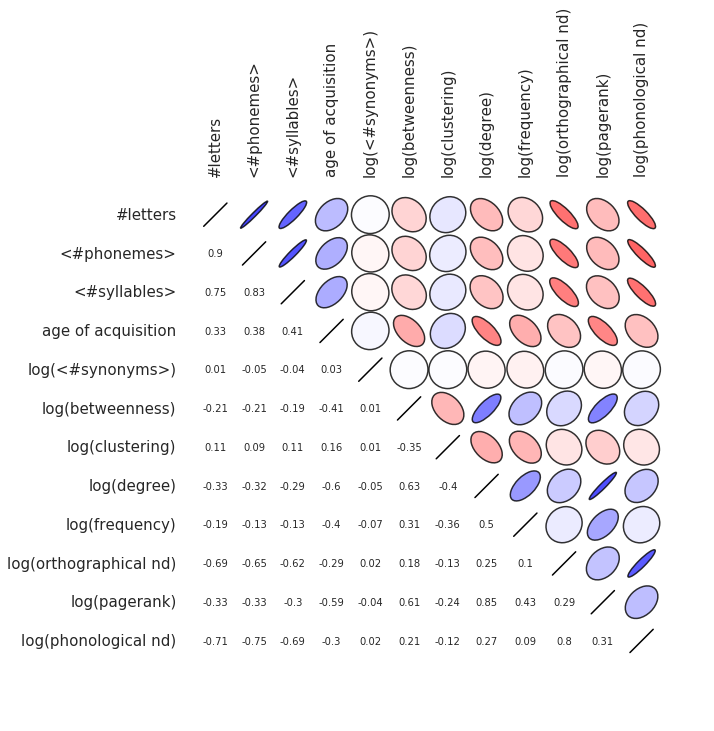

In [8]:
pretty_plot_correlations(tfeatures, scaling=2.5, cor_fontsize=10, label_fontsize=15)

## 4 PCA on features